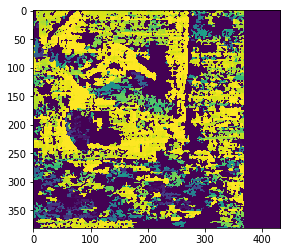

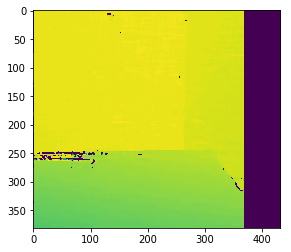

In [1]:

import cv2

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
 
import sys
import numpy as np
import glob
# 视差计算
def disparity_SGBM(left_image, right_image, down_scale=False):
    numberOfDisparities = int((width / 8) + 15) & -16
    # SGBM匹配参数设置
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    param = {'minDisparity': -numberOfDisparities,
             'numDisparities': numberOfDisparities,
             'blockSize': blockSize,
             'P1': 8 * img_channels * blockSize ** 2,
             'P2': 32 * img_channels * blockSize ** 2,
             'disp12MaxDiff': 1,
             'preFilterCap': 32,
             'uniquenessRatio': 10,
             'speckleWindowSize': 200,
             'speckleRange': 32,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    # 构建SGBM对象
    sgbm = cv2.StereoSGBM_create(**param)
 
    # 计算视差图
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = sgbm.compute(left_image, right_image)
        disparity_right = sgbm.compute(right_image, left_image)
    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = size[0] / left_image_down.shape[1]
        disparity_left_half = sgbm.compute(left_image_down, right_image_down)
        disparity_right_half = sgbm.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA) 
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left *= factor 
        disparity_right *= factor
 
    return disparity_left, disparity_right
imgL = cv2.imread("im2.ppm")
imgR = cv2.imread("im6.ppm")

height, width = imgL.shape[0:2] 
iml_rectified = imgL
imr_rectified = imgR
# 计算视差
lookdispL,lookdispR = disparity_SGBM(iml_rectified  , imr_rectified )

plt.imshow(lookdispL)  
plt.show()
plt.imshow(lookdispR)  
plt.show()

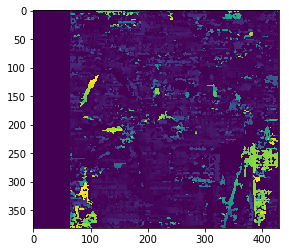

In [34]:
plt.imshow(lookdispR)    

In [18]:
    numberOfDisparities = int((width / 8) + 15) & -16
    numberOfDisparities

64

In [16]:
width/8

53.75

In [2]:

plt.imshow(disparity_left)
# plt.imshow(disparity_left_color)


NameError: name 'disparity_left' is not defined

computing SGNM_disparity...


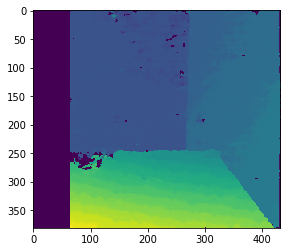

In [13]:
import numpy as np
import cv2
import time
def SGBM_update(val=0):
    global SGBM_num
    global SGBM_blockSize
    SGBM_blockSize=cv2.getTrackbarPos('blockSize', 'SGNM_disparity')
    if SGBM_blockSize % 2 == 0:
        SGBM_blockSize += 1
    if SGBM_blockSize < 5:
        SGBM_blockSize = 5
    SGBM_stereo.setBlockSize(SGBM_blockSize)
    SGBM_num=cv2.getTrackbarPos('num_disp', 'SGNM_disparity')
    num_disp = SGBM_num * 16
#     SGBM_stereo.setMinDisparity(-num_disp)
    SGBM_stereo.setNumDisparities(num_disp)

    SGBM_stereo.setUniquenessRatio(cv2.getTrackbarPos('unique_Ratio', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleWindowSize(cv2.getTrackbarPos('spec_WinSize', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleRange(cv2.getTrackbarPos('spec_Range', 'SGNM_disparity'))
    SGBM_stereo.setDisp12MaxDiff(cv2.getTrackbarPos('disp12MaxDiff', 'SGNM_disparity'))

    print('computing SGNM_disparity...')
    displ = SGBM_stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    dispr = SGBM_stereo.compute(imgR, imgL).astype(np.float32) / 16.0
    return displ,dispr



if __name__ == "__main__":
#     start = time.clock()
    SGBM_blockSize = 5 #一个匹配块的大小,大于1的奇数
    SGBM_num = 4
    min_disp = 0   #最小的视差值，通常情况下为0
    num_disp =SGBM_num * 16      #192 - min_disp #视差范围，即最大视差值和最小视差值之差，必须是16的倍数。
    #blockSize = blockSize #匹配块大小（SADWindowSize），必须是大于等于1的奇数，一般为3~11
    uniquenessRatio = 6 #视差唯一性百分比， 视差窗口范围内最低代价是次低代价的(1 + uniquenessRatio/100)倍时，最低代价对应的视差值才是该像素点的视差，否则该像素点的视差为 0，通常为5~15.
    speckleRange = 2 #视差变化阈值，每个连接组件内的最大视差变化。如果你做斑点过滤，将参数设置为正值，它将被隐式乘以16.通常，1或2就足够好了
    speckleWindowSize = 100#平滑视差区域的最大尺寸，以考虑其噪声斑点和无效。将其设置为0可禁用斑点过滤。否则，将其设置在50-200的范围内。
    disp12MaxDiff = 200 #左右视差图的最大容许差异（超过将被清零），默认为 -1，即不执行左右视差检查。
    P1 = 600  #惩罚系数，一般：P1=8*通道数*SADWindowSize*SADWindowSize，P2=4*P1
    P2 = 240 #p1控制视差平滑度，p2值越大，差异越平滑

    imgL = cv2.imread('im2.ppm')
    imgR = cv2.imread('im6.ppm')

    cv2.namedWindow('SGNM_disparity')
    cv2.createTrackbar('blockSize', 'SGNM_disparity', SGBM_blockSize, 21, SGBM_update)
    cv2.createTrackbar('num_disp', 'SGNM_disparity', SGBM_num, 20, SGBM_update)
    cv2.createTrackbar('spec_Range', 'SGNM_disparity', speckleRange, 50, SGBM_update)#设置trackbar来调节参数
    cv2.createTrackbar('spec_WinSize', 'SGNM_disparity', speckleWindowSize, 200, SGBM_update)
    cv2.createTrackbar('unique_Ratio', 'SGNM_disparity', uniquenessRatio, 50, SGBM_update)
    cv2.createTrackbar('disp12MaxDiff', 'SGNM_disparity', disp12MaxDiff, 250, SGBM_update)

    SGBM_stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,  # 最小的视差值
        numDisparities=num_disp,  # 视差范围
        
        blockSize=SGBM_blockSize,  # 匹配块大小（SADWindowSize）
        uniquenessRatio=uniquenessRatio,  # 视差唯一性百分比
        speckleRange=speckleRange,  # 视差变化阈值
        speckleWindowSize=speckleWindowSize,
        disp12MaxDiff=disp12MaxDiff,  # 左右视差图的最大容许差异
        P1=P1,  # 惩罚系数
        P2=P2
    )

    displ,dispr = SGBM_update()
    plt.imshow( (displ - min_disp) / num_disp)
    plt.show()
#     plt.imshow( (dispr - min_disp) / num_disp)
#     plt.show()

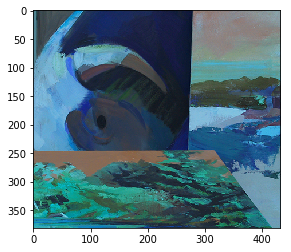

In [4]:
plt.imshow(imgL)

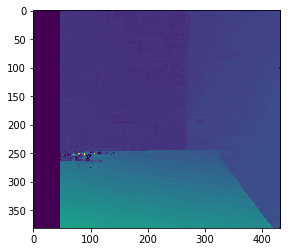

In [5]:
imgL = cv2.imread('im2.ppm')
imgR = cv2.imread('im6.ppm')

blockSize = 3
img_channels = 3

param = {'minDisparity': 0,
         'numDisparities': 48,
         'blockSize': blockSize,
         'P1': 8 * img_channels * blockSize ** 2,
         'P2': 32 * img_channels * blockSize ** 2,
         'disp12MaxDiff': 12,
         'preFilterCap': 1,
         'uniquenessRatio': 5,
         'speckleWindowSize': 1,
         'speckleRange': 100,
         'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
         }

# 构建SGBM对象
sgbm = cv2.StereoSGBM_create(**param)
disparity_left = sgbm.compute(imgL, imgR)
plt.imshow(disparity_left)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

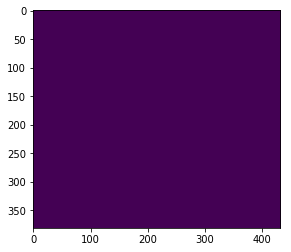

In [6]:
disparity_left.min()
displ = abs(displ)
# 用视差获取深度
baseline = 20
fx = 900
depth = np.ones_like(disparity_left, dtype=np.uint8)
for i in range(height):
    for j in range(width):
        if lookdispL[i][j]<5: ##噪音
            depth[i][j]=0
        else:
            depth[i][j] = fx*baseline/(disparity_left[i][j])
cv2.medianBlur(depth,3)
plt.imshow(depth)
depth

computing SGNM_disparity...


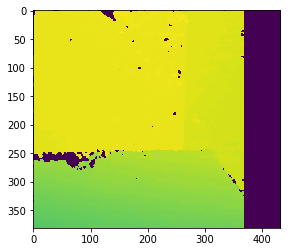

In [7]:
import numpy as np
import cv2
import time
def SGBM_update(val=0):
    global SGBM_num
    global SGBM_blockSize
    SGBM_blockSize=cv2.getTrackbarPos('blockSize', 'SGNM_disparity')
    if SGBM_blockSize % 2 == 0:
        SGBM_blockSize += 1
    if SGBM_blockSize < 5:
        SGBM_blockSize = 5
    SGBM_stereo.setBlockSize(SGBM_blockSize)
    SGBM_num=cv2.getTrackbarPos('num_disp', 'SGNM_disparity')
    num_disp = SGBM_num * 16
    SGBM_stereo.setMinDisparity(-num_disp)
    SGBM_stereo.setNumDisparities(num_disp)

    SGBM_stereo.setUniquenessRatio(cv2.getTrackbarPos('unique_Ratio', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleWindowSize(cv2.getTrackbarPos('spec_WinSize', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleRange(cv2.getTrackbarPos('spec_Range', 'SGNM_disparity'))
    SGBM_stereo.setDisp12MaxDiff(cv2.getTrackbarPos('disp12MaxDiff', 'SGNM_disparity'))

    print('computing SGNM_disparity...')
    displ = SGBM_stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    dispr = SGBM_stereo.compute(imgR, imgL).astype(np.float32) / 16.0
    return displ,dispr


if __name__ == "__main__":
#     start = time.clock()
    SGBM_blockSize = 5 #一个匹配块的大小,大于1的奇数
    SGBM_num = 4
    min_disp = 0   #最小的视差值，通常情况下为0
    num_disp =SGBM_num * 16      #192 - min_disp #视差范围，即最大视差值和最小视差值之差，必须是16的倍数。
    #blockSize = blockSize #匹配块大小（SADWindowSize），必须是大于等于1的奇数，一般为3~11
    uniquenessRatio = 6 #视差唯一性百分比， 视差窗口范围内最低代价是次低代价的(1 + uniquenessRatio/100)倍时，最低代价对应的视差值才是该像素点的视差，否则该像素点的视差为 0，通常为5~15.
    speckleRange = 2 #视差变化阈值，每个连接组件内的最大视差变化。如果你做斑点过滤，将参数设置为正值，它将被隐式乘以16.通常，1或2就足够好了
    speckleWindowSize = 100#平滑视差区域的最大尺寸，以考虑其噪声斑点和无效。将其设置为0可禁用斑点过滤。否则，将其设置在50-200的范围内。
    disp12MaxDiff = 200 #左右视差图的最大容许差异（超过将被清零），默认为 -1，即不执行左右视差检查。
    P1 = 600  #惩罚系数，一般：P1=8*通道数*SADWindowSize*SADWindowSize，P2=4*P1
    P2 = 240 #p1控制视差平滑度，p2值越大，差异越平滑

    imgL = cv2.imread('im2.ppm')
    imgR = cv2.imread('im6.ppm')

    cv2.namedWindow('SGNM_disparity')
    cv2.createTrackbar('blockSize', 'SGNM_disparity', SGBM_blockSize, 21, SGBM_update)
    cv2.createTrackbar('num_disp', 'SGNM_disparity', SGBM_num, 20, SGBM_update)
    cv2.createTrackbar('spec_Range', 'SGNM_disparity', speckleRange, 50, SGBM_update)#设置trackbar来调节参数
    cv2.createTrackbar('spec_WinSize', 'SGNM_disparity', speckleWindowSize, 200, SGBM_update)
    cv2.createTrackbar('unique_Ratio', 'SGNM_disparity', uniquenessRatio, 50, SGBM_update)
    cv2.createTrackbar('disp12MaxDiff', 'SGNM_disparity', disp12MaxDiff, 250, SGBM_update)

    SGBM_stereo = cv2.StereoSGBM_create(
        minDisparity   = min_disp,  # 最小的视差值
        numDisparities = num_disp,  # 视差范围
        
        blockSize=SGBM_blockSize,  # 匹配块大小（SADWindowSize）
        uniquenessRatio=uniquenessRatio,  # 视差唯一性百分比
        speckleRange=speckleRange,  # 视差变化阈值
        speckleWindowSize=speckleWindowSize,
        disp12MaxDiff=disp12MaxDiff,  # 左右视差图的最大容许差异
        P1=P1,  # 惩罚系数
        P2=P2
    )

    displ,dispr = SGBM_update()
#     plt.imshow( (displ - min_disp) / num_disp)
#     plt.show()
    plt.imshow( (dispr - min_disp) / num_disp)
    plt.show()

计算深度

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

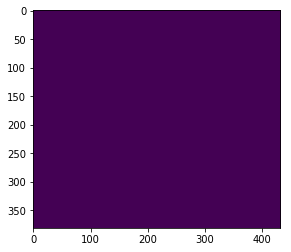

In [9]:
displ = abs(displ)
# 用视差获取深度
baseline = 20
fx = 1000
depth = np.ones_like(lookdispL, dtype=np.uint8)
for i in range(height):
    for j in range(width):
        if lookdispL[i][j]<5: ##噪音
            depth[i][j]=0
        else:
            depth[i][j] = fx*baseline/(displ[i][j])
cv2.medianBlur(depth,3)
plt.imshow(depth)
depth

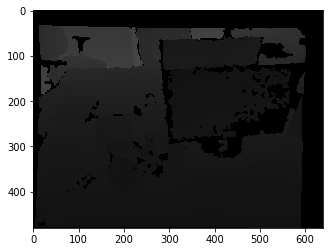

480 640


array([0, 0, 0], dtype=uint8)

In [11]:
depth = cv2.imread('rgbd_depth.png')
plt.imshow(depth)
plt.show()
height, width = depth.shape[0:2]
print(height,width)
depth[300][440]

In [190]:
a = np.array([2.49631603, -1.04573414 ,47.31952137])
np.linalg.norm(a)

47.39685913959999

In [3]:
pwd

'/Users/chenshiming/Desktop/工作资料/学习资料/python资料'

## 寻找圆点

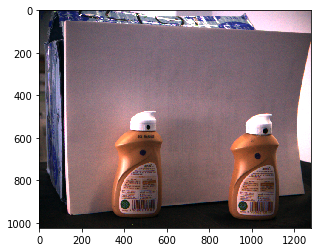

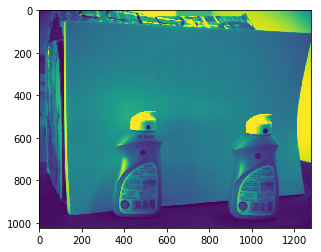

(1024, 1280)


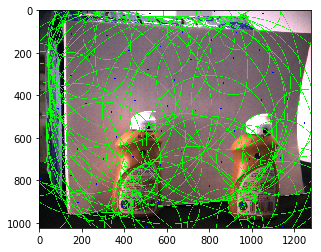

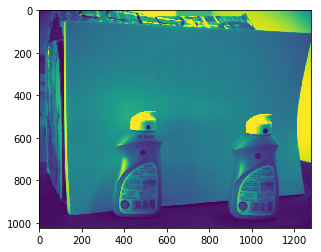

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
 

planets = cv2.imread('pingzi_L.bmp')
plt.imshow(planets)
plt.show()
gray_img = cv2.cvtColor(planets, cv2.COLOR_BGR2GRAY)
img = cv2.medianBlur(gray_img, 5)
plt.imshow(img)
plt.show()
print(img.shape)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 120, param1=100, param2=30, minRadius=0, maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0, :]:
    # draw the outer circle
    cv2.circle(planets, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # draw the center of the circle
    cv2.circle(planets, (i[0], i[1]), 2, (0, 0, 255), 3)
plt.imshow(planets)
plt.show()





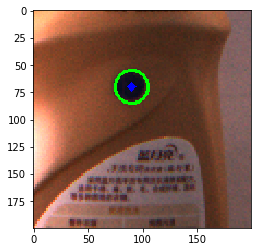

In [35]:
planets = cv2.imread('pingzi_L.bmp')
tpplanets = planets[600:800,400:600]
gray_img_2 = cv2.cvtColor(tpplanets, cv2.COLOR_BGR2GRAY)
img2 = cv2.medianBlur(gray_img_2, 5)

plt.imshow(img2)
circles = cv2.HoughCircles(img2, cv2.HOUGH_GRADIENT, 1, 120, param1=100, param2=30, minRadius=0, maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    # draw the outer circle
    cv2.circle(tpplanets, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # draw the center of the circle
    cv2.circle(tpplanets, (i[0], i[1]), 2, (0, 0, 255), 3)
plt.imshow(tpplanets)
plt.show()

In [33]:
circles

array([[[90, 70, 15]]], dtype=uint16)

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


def icp(a, b, init_pose=(0,0,0), no_iterations = 13):
    '''
    The Iterative Closest Point estimator.
    Takes two cloudpoints a[x,y], b[x,y], an initial estimation of
    their relative pose and the number of iterations
    Returns the affine transform that transforms
    the cloudpoint a to the cloudpoint b.
    Note:
        (1) This method works for cloudpoints with minor
        transformations. Thus, the result depents greatly on
        the initial pose estimation.
        (2) A large number of iterations does not necessarily
        ensure convergence. Contrarily, most of the time it
        produces worse results.
    '''

    src = np.array([a.T], copy=True).astype(np.float32)
    dst = np.array([b.T], copy=True).astype(np.float32)

    #Initialise with the initial pose estimation
    Tr = np.array([[np.cos(init_pose[2]),-np.sin(init_pose[2]),init_pose[0]],
                   [np.sin(init_pose[2]), np.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])

    src = cv2.transform(src, Tr[0:2])

    for i in range(no_iterations):
        #Find the nearest neighbours between the current source and the
        #destination cloudpoint
#         nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto',
#                                 warn_on_equidistant=False).fit(dst[0])
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto',).fit(dst[0])
        distances, indices = nbrs.kneighbors(src[0])

        #Compute the transformation between the current source
        #and destination cloudpoint
        T = cv2.estimateAffinePartial2D(src, dst[0, indices.T], False)
        #Transform the previous source and update the
        #current source cloudpoint
        src = cv2.transform(src, T)
        #Save the transformation from the actual source cloudpoint
        #to the destination
        Tr = np.dot(Tr, np.vstack((T,[0,0,1])))
    return Tr[0:2]

In [58]:
#Create the datasets
ang = np.linspace(-np.pi/2, np.pi/2, 320)
a = np.array([ang, np.sin(ang)])
th = np.pi/2
rot = np.array([[np.cos(th), -np.sin(th)],[np.sin(th), np.cos(th)]])
b = np.dot(rot, a) + np.array([[0.2], [0.3]])

#Run the icp
M2 = icp(a, b, [0.1,  0.33, np.pi/2.2], 30)

#Plot the result
src = np.array([a.T]).astype(np.float32)
res = cv2.transform(src, M2)
plt.figure()
plt.plot(b[0],b[1])
plt.plot(res[0].T[0], res[0].T[1], 'r.')
plt.plot(a[0], a[1])
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'm'